# <font color='blue'>Imports </font>

In [53]:
%%time
import pandas as pd
import numpy as np
import seaborn as sns
import lightgbm
import optuna
import optuna.integration.lightgbm as lgb
import matplotlib.lines as line
import matplotlib.ticker as ticker
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import rc
import sklearn.datasets as skd
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score, explained_variance_score, confusion_matrix, accuracy_score, classification_report, log_loss, brier_score_loss, f1_score

Wall time: 0 ns


In [2]:
%%time
path = 'D:\\Documents\\GitHub\\Classification_datascience\\webscrapping\\matches\\rounds\\'
dataset = pd.read_csv('{}combined_csv.csv'.format(path))

Wall time: 398 ms


In [3]:
dataset.columns

Index(['RoundID', 'RoundNumber', 'RoundTime', 'ATK_wealth', 'DEF_wealth',
       'ATK_alive', 'DEF_alive', 'DEF_has_OP', 'Def_has_Odin', 'RegularTime',
       'SpikeTime', 'ATK_bank', 'DEF_bank', 'ATK_initiators', 'ATK_duelists',
       'ATK_sentinels', 'ATK_controllers', 'DEF_initiators', 'DEF_duelists',
       'DEF_sentinels', 'DEF_controllers', 'ATK_Shields', 'DEF_Shields',
       'MapName', 'MatchID', 'SeriesID', 'bestOF', 'FinalWinner'],
      dtype='object')

# <font color='blue'> Predict variable </font>

In [4]:
selected_features = ['ATK_wealth', 'DEF_wealth',
                   'ATK_initiators', 'ATK_duelists', 'ATK_sentinels', 'ATK_controllers',
                   'DEF_initiators', 'DEF_duelists', 'DEF_sentinels', 'DEF_controllers',
                     'ATK_Shields', 'DEF_Shields',
                   'DEF_has_OP', 'Def_has_Odin',
                    'RegularTime', 'SpikeTime',
                   'MapName',
                   'FinalWinner']

predict_variable = 'FinalWinner'

### <font color='black'> Trimming dataframe </font>

In [5]:
dataset = dataset[selected_features]

if 'MapName' in dataset.columns:
    dataset = pd.get_dummies(dataset, columns=['MapName'])
    
X = dataset.drop([predict_variable], axis='columns')
Y = dataset[predict_variable]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=15)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, train_size=0.9, test_size=0.1, random_state=15)

In [6]:
dataset.head()

,ATK_wealth,DEF_wealth,ATK_initiators,ATK_duelists,ATK_sentinels,ATK_controllers,DEF_initiators,DEF_duelists,DEF_sentinels,DEF_controllers,...,Def_has_Odin,RegularTime,SpikeTime,FinalWinner,MapName_Ascent,MapName_Bind,MapName_Breeze,MapName_Haven,MapName_Icebox,MapName_Split
0,2500,0,1,2,1,1,1,1,2,1,...,0,0,0,0,0,0,0,1,0,0
1,2500,0,1,2,1,1,1,0,2,1,...,0,21,0,0,0,0,0,1,0,0
2,2000,0,1,1,1,1,1,0,2,1,...,0,22,0,0,0,0,0,1,0,0
3,1500,0,1,0,1,1,1,0,2,1,...,0,24,0,0,0,0,0,1,0,0
4,1000,0,0,0,1,1,1,0,2,1,...,0,26,0,0,0,0,0,1,0,0


# <font color='blue'>Parameter tuning </font>

In [7]:
def objective(trial):
    bagging_freq =  trial.suggest_int('bagging_freq',1,10),
    min_data_in_leaf =  trial.suggest_int('min_data_in_leaf',2,100),
    max_depth = trial.suggest_int('max_depth',1,20),
    learning_rate = trial.suggest_loguniform('learning_rate',0.001,0.1),
    num_leaves = trial.suggest_int('num_leaves',2,70),
    num_threads = trial.suggest_int('num_threads',1,10),
    min_sum_hessian_in_leaf = trial.suggest_int('min_sum_hessian_in_leaf',1,10),
    
    model = lightgbm.LGBMClassifier(bagging_freq=bagging_freq,
                                    min_data_in_leaf=min_data_in_leaf,
                                   max_depth=max_depth,
                                   learning_rate=learning_rate,
                                   num_leaves=num_leaves,
                                   num_threads=num_threads,
                                   min_sum_hessian_in_leaf=min_sum_hessian_in_leaf)
    model.fit(X_train,Y_train)
    pred_proba_test = model.predict_proba(X_test)
    score = brier_score_loss(Y_test, pd.DataFrame(pred_proba_test)[1])
    return score

In [8]:
%%time
study = optuna.create_study()
study.optimize(objective, n_trials=50)

[I 2021-06-21 18:38:25,801] A new study created in memory with name: no-name-58893db5-d1be-479d-a4d3-694b3f983756


[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] num_threads is set=3, n_jobs=-1 will be ignored. Current value: num_threads=3
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-06-21 18:38:26,325] Trial 0 finished with value: 0.2034577063813569 and parameters: {'bagging_freq': 7, 'min_data_in_leaf': 25, 'max_depth': 1, 'learning_rate': 0.012003121853070347, 'num_leaves': 4, 'num_threads': 3, 'min_sum_hessian_in_leaf': 8}. Best is trial 0 with value: 0.2034577063813569.


[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-06-21 18:38:28,672] Trial 1 finished with value: 0.21722709492099332 and parameters: {'bagging_freq': 5, 'min_data_in_leaf': 46, 'max_depth': 15, 'learning_rate': 0.0018425345830344658, 'num_leaves': 34, 'num_threads': 1, 'min_sum_hessian_in_leaf': 1}. Best is trial 0 with value: 0.2034577063813569.


[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4
[LightGBM] [Warning] num_threads is set=7, n_jobs=-1 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-06-21 18:38:29,767] Trial 2 finished with value: 0.13994338178753563 and parameters: {'bagging_freq': 4, 'min_data_in_leaf': 4, 'max_depth': 6, 'learning_rate': 0.01801904152079484, 'num_leaves': 54, 'num_threads': 7, 'min_sum_hessian_in_leaf': 4}. Best is trial 2 with value: 0.13994338178753563.


[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4
[LightGBM] [Warning] num_threads is set=9, n_jobs=-1 will be ignored. Current value: num_threads=9
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-06-21 18:38:30,687] Trial 3 finished with value: 0.2027374824375785 and parameters: {'bagging_freq': 6, 'min_data_in_leaf': 51, 'max_depth': 6, 'learning_rate': 0.002913182086391682, 'num_leaves': 37, 'num_threads': 9, 'min_sum_hessian_in_leaf': 4}. Best is trial 2 with value: 0.13994338178753563.


[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4
[LightGBM] [Warning] num_threads is set=3, n_jobs=-1 will be ignored. Current value: num_threads=3
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-06-21 18:38:31,677] Trial 4 finished with value: 0.19296218024983833 and parameters: {'bagging_freq': 2, 'min_data_in_leaf': 7, 'max_depth': 5, 'learning_rate': 0.0039138649471012026, 'num_leaves': 48, 'num_threads': 3, 'min_sum_hessian_in_leaf': 4}. Best is trial 2 with value: 0.13994338178753563.


[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-06-21 18:38:32,287] Trial 5 finished with value: 0.18242866844016617 and parameters: {'bagging_freq': 6, 'min_data_in_leaf': 29, 'max_depth': 13, 'learning_rate': 0.006914390043151525, 'num_leaves': 6, 'num_threads': 4, 'min_sum_hessian_in_leaf': 10}. Best is trial 2 with value: 0.13994338178753563.


[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=6, n_jobs=-1 will be ignored. Current value: num_threads=6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-06-21 18:38:32,708] Trial 6 finished with value: 0.1464071423484439 and parameters: {'bagging_freq': 1, 'min_data_in_leaf': 64, 'max_depth': 14, 'learning_rate': 0.03282056180893848, 'num_leaves': 4, 'num_threads': 6, 'min_sum_hessian_in_leaf': 2}. Best is trial 2 with value: 0.13994338178753563.


[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=9, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=9
[LightGBM] [Warning] num_threads is set=9, n_jobs=-1 will be ignored. Current value: num_threads=9
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-06-21 18:38:33,499] Trial 7 finished with value: 0.21449932030657928 and parameters: {'bagging_freq': 2, 'min_data_in_leaf': 90, 'max_depth': 5, 'learning_rate': 0.0020782105430699155, 'num_leaves': 60, 'num_threads': 9, 'min_sum_hessian_in_leaf': 9}. Best is trial 2 with value: 0.13994338178753563.


[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2021-06-21 18:38:34,248] Trial 8 finished with value: 0.15624718732364823 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 67, 'max_depth': 16, 'learning_rate': 0.009655415964671421, 'num_leaves': 39, 'num_threads': 5, 'min_sum_hessian_in_leaf': 2}. Best is trial 2 with value: 0.13994338178753563.


[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3
[LightGBM] [Warning] num_threads is set=7, n_jobs=-1 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2021-06-21 18:38:35,168] Trial 9 finished with value: 0.12895141175767746 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 49, 'max_depth': 14, 'learning_rate': 0.09408188064485125, 'num_leaves': 36, 'num_threads': 7, 'min_sum_hessian_in_leaf': 3}. Best is trial 9 with value: 0.12895141175767746.


[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] num_threads is set=10, n_jobs=-1 will be ignored. Current value: num_threads=10
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2021-06-21 18:38:35,881] Trial 10 finished with value: 0.1297644631786722 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 94, 'max_depth': 19, 'learning_rate': 0.09958083588446803, 'num_leaves': 21, 'num_threads': 10, 'min_sum_hessian_in_leaf': 7}. Best is trial 9 with value: 0.12895141175767746.


[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] num_threads is set=10, n_jobs=-1 will be ignored. Current value: num_threads=10
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2021-06-21 18:38:36,599] Trial 11 finished with value: 0.13001432433867513 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 91, 'max_depth': 20, 'learning_rate': 0.09640198818547836, 'num_leaves': 21, 'num_threads': 10, 'min_sum_hessian_in_leaf': 7}. Best is trial 9 with value: 0.12895141175767746.


[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2021-06-21 18:38:37,375] Trial 12 finished with value: 0.12992363587427258 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 74, 'max_depth': 20, 'learning_rate': 0.09796308947237278, 'num_leaves': 21, 'num_threads': 8, 'min_sum_hessian_in_leaf': 6}. Best is trial 9 with value: 0.12895141175767746.


[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] num_threads is set=10, n_jobs=-1 will be ignored. Current value: num_threads=10
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2021-06-21 18:38:38,139] Trial 13 finished with value: 0.13256630013245388 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 41, 'max_depth': 18, 'learning_rate': 0.04843479642054662, 'num_leaves': 23, 'num_threads': 10, 'min_sum_hessian_in_leaf': 5}. Best is trial 9 with value: 0.12895141175767746.


[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] num_threads is set=7, n_jobs=-1 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2021-06-21 18:38:39,049] Trial 14 finished with value: 0.13102673093534073 and parameters: {'bagging_freq': 8, 'min_data_in_leaf': 80, 'max_depth': 10, 'learning_rate': 0.060359235269779, 'num_leaves': 28, 'num_threads': 7, 'min_sum_hessian_in_leaf': 6}. Best is trial 9 with value: 0.12895141175767746.


[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2021-06-21 18:38:40,178] Trial 15 finished with value: 0.1336989568368798 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 59, 'max_depth': 11, 'learning_rate': 0.025754334964465272, 'num_leaves': 70, 'num_threads': 8, 'min_sum_hessian_in_leaf': 3}. Best is trial 9 with value: 0.12895141175767746.


[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] num_threads is set=10, n_jobs=-1 will be ignored. Current value: num_threads=10
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2021-06-21 18:38:40,838] Trial 16 finished with value: 0.13234032633313292 and parameters: {'bagging_freq': 8, 'min_data_in_leaf': 25, 'max_depth': 18, 'learning_rate': 0.06839081914476501, 'num_leaves': 13, 'num_threads': 10, 'min_sum_hessian_in_leaf': 8}. Best is trial 9 with value: 0.12895141175767746.


[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] num_threads is set=7, n_jobs=-1 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2021-06-21 18:38:41,867] Trial 17 finished with value: 0.13199615891087113 and parameters: {'bagging_freq': 8, 'min_data_in_leaf': 98, 'max_depth': 17, 'learning_rate': 0.03885525368743627, 'num_leaves': 45, 'num_threads': 7, 'min_sum_hessian_in_leaf': 1}. Best is trial 9 with value: 0.12895141175767746.


[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2021-06-21 18:38:42,471] Trial 18 finished with value: 0.230897895159722 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 39, 'max_depth': 11, 'learning_rate': 0.0010862160020992295, 'num_leaves': 14, 'num_threads': 5, 'min_sum_hessian_in_leaf': 7}. Best is trial 9 with value: 0.12895141175767746.


[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] num_threads is set=9, n_jobs=-1 will be ignored. Current value: num_threads=9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-06-21 18:38:43,303] Trial 19 finished with value: 0.1292864833644923 and parameters: {'bagging_freq': 4, 'min_data_in_leaf': 56, 'max_depth': 20, 'learning_rate': 0.09690117494917248, 'num_leaves': 30, 'num_threads': 9, 'min_sum_hessian_in_leaf': 5}. Best is trial 9 with value: 0.12895141175767746.


[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-06-21 18:38:44,237] Trial 20 finished with value: 0.13804552469094114 and parameters: {'bagging_freq': 3, 'min_data_in_leaf': 55, 'max_depth': 9, 'learning_rate': 0.021965994803262796, 'num_leaves': 32, 'num_threads': 8, 'min_sum_hessian_in_leaf': 5}. Best is trial 9 with value: 0.12895141175767746.


[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] num_threads is set=9, n_jobs=-1 will be ignored. Current value: num_threads=9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-06-21 18:38:45,020] Trial 21 finished with value: 0.1294412848470227 and parameters: {'bagging_freq': 4, 'min_data_in_leaf': 81, 'max_depth': 20, 'learning_rate': 0.09489073072014963, 'num_leaves': 27, 'num_threads': 9, 'min_sum_hessian_in_leaf': 7}. Best is trial 9 with value: 0.12895141175767746.


[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3
[LightGBM] [Warning] num_threads is set=9, n_jobs=-1 will be ignored. Current value: num_threads=9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-06-21 18:38:45,899] Trial 22 finished with value: 0.12958957002158122 and parameters: {'bagging_freq': 4, 'min_data_in_leaf': 80, 'max_depth': 20, 'learning_rate': 0.07110512627445102, 'num_leaves': 41, 'num_threads': 9, 'min_sum_hessian_in_leaf': 3}. Best is trial 9 with value: 0.12895141175767746.


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] num_threads is set=6, n_jobs=-1 will be ignored. Current value: num_threads=6
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-06-21 18:38:46,545] Trial 23 finished with value: 0.1293052644332608 and parameters: {'bagging_freq': 4, 'min_data_in_leaf': 35, 'max_depth': 16, 'learning_rate': 0.09759515654916781, 'num_leaves': 28, 'num_threads': 6, 'min_sum_hessian_in_leaf': 5}. Best is trial 9 with value: 0.12895141175767746.


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3
[LightGBM] [Warning] num_threads is set=6, n_jobs=-1 will be ignored. Current value: num_threads=6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-06-21 18:38:47,237] Trial 24 finished with value: 0.13156092611587394 and parameters: {'bagging_freq': 5, 'min_data_in_leaf': 35, 'max_depth': 13, 'learning_rate': 0.051512756688707174, 'num_leaves': 30, 'num_threads': 6, 'min_sum_hessian_in_leaf': 3}. Best is trial 9 with value: 0.12895141175767746.


[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] num_threads is set=6, n_jobs=-1 will be ignored. Current value: num_threads=6
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-06-21 18:38:47,968] Trial 25 finished with value: 0.12908352919004384 and parameters: {'bagging_freq': 3, 'min_data_in_leaf': 19, 'max_depth': 16, 'learning_rate': 0.0775145526456695, 'num_leaves': 45, 'num_threads': 6, 'min_sum_hessian_in_leaf': 5}. Best is trial 9 with value: 0.12895141175767746.


[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4
[LightGBM] [Warning] num_threads is set=7, n_jobs=-1 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-06-21 18:38:48,994] Trial 26 finished with value: 0.13212171639421288 and parameters: {'bagging_freq': 3, 'min_data_in_leaf': 13, 'max_depth': 13, 'learning_rate': 0.03611077885537503, 'num_leaves': 51, 'num_threads': 7, 'min_sum_hessian_in_leaf': 4}. Best is trial 9 with value: 0.12895141175767746.


[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-06-21 18:38:49,804] Trial 27 finished with value: 0.12944434893520668 and parameters: {'bagging_freq': 1, 'min_data_in_leaf': 16, 'max_depth': 17, 'learning_rate': 0.06913536846691018, 'num_leaves': 44, 'num_threads': 5, 'min_sum_hessian_in_leaf': 2}. Best is trial 9 with value: 0.12895141175767746.


[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-06-21 18:38:50,815] Trial 28 finished with value: 0.13047734685825507 and parameters: {'bagging_freq': 3, 'min_data_in_leaf': 49, 'max_depth': 15, 'learning_rate': 0.04837506868646865, 'num_leaves': 55, 'num_threads': 8, 'min_sum_hessian_in_leaf': 6}. Best is trial 9 with value: 0.12895141175767746.


[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-06-21 18:38:53,559] Trial 29 finished with value: 0.13360070365354815 and parameters: {'bagging_freq': 2, 'min_data_in_leaf': 19, 'max_depth': 18, 'learning_rate': 0.027335838895360856, 'num_leaves': 60, 'num_threads': 1, 'min_sum_hessian_in_leaf': 5}. Best is trial 9 with value: 0.12895141175767746.


[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4
[LightGBM] [Warning] num_threads is set=3, n_jobs=-1 will be ignored. Current value: num_threads=3
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-06-21 18:38:54,642] Trial 30 finished with value: 0.15055304612327475 and parameters: {'bagging_freq': 7, 'min_data_in_leaf': 66, 'max_depth': 15, 'learning_rate': 0.011436434756235887, 'num_leaves': 42, 'num_threads': 3, 'min_sum_hessian_in_leaf': 4}. Best is trial 9 with value: 0.12895141175767746.


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] num_threads is set=6, n_jobs=-1 will be ignored. Current value: num_threads=6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-06-21 18:38:55,329] Trial 31 finished with value: 0.12891533013311798 and parameters: {'bagging_freq': 5, 'min_data_in_leaf': 35, 'max_depth': 16, 'learning_rate': 0.09906460622340729, 'num_leaves': 35, 'num_threads': 6, 'min_sum_hessian_in_leaf': 5}. Best is trial 31 with value: 0.12891533013311798.


[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-06-21 18:38:56,206] Trial 32 finished with value: 0.12941910784806498 and parameters: {'bagging_freq': 5, 'min_data_in_leaf': 26, 'max_depth': 12, 'learning_rate': 0.0811198431385145, 'num_leaves': 35, 'num_threads': 4, 'min_sum_hessian_in_leaf': 6}. Best is trial 31 with value: 0.12891533013311798.


[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3
[LightGBM] [Warning] num_threads is set=6, n_jobs=-1 will be ignored. Current value: num_threads=6
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-06-21 18:38:56,942] Trial 33 finished with value: 0.14246472057517418 and parameters: {'bagging_freq': 6, 'min_data_in_leaf': 45, 'max_depth': 16, 'learning_rate': 0.01642587952850763, 'num_leaves': 35, 'num_threads': 6, 'min_sum_hessian_in_leaf': 3}. Best is trial 31 with value: 0.12891533013311798.


[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] num_threads is set=7, n_jobs=-1 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-06-21 18:38:57,988] Trial 34 finished with value: 0.13093768864440433 and parameters: {'bagging_freq': 4, 'min_data_in_leaf': 32, 'max_depth': 14, 'learning_rate': 0.05296859981515885, 'num_leaves': 38, 'num_threads': 7, 'min_sum_hessian_in_leaf': 5}. Best is trial 31 with value: 0.12891533013311798.


[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-06-21 18:38:58,462] Trial 35 finished with value: 0.15163370269668186 and parameters: {'bagging_freq': 5, 'min_data_in_leaf': 43, 'max_depth': 1, 'learning_rate': 0.07950853545701822, 'num_leaves': 47, 'num_threads': 4, 'min_sum_hessian_in_leaf': 4}. Best is trial 31 with value: 0.12891533013311798.


[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-06-21 18:38:59,240] Trial 36 finished with value: 0.13238775386468754 and parameters: {'bagging_freq': 3, 'min_data_in_leaf': 53, 'max_depth': 15, 'learning_rate': 0.0427239465680209, 'num_leaves': 32, 'num_threads': 5, 'min_sum_hessian_in_leaf': 1}. Best is trial 31 with value: 0.12891533013311798.


[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4
[LightGBM] [Warning] num_threads is set=6, n_jobs=-1 will be ignored. Current value: num_threads=6
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-06-21 18:38:59,967] Trial 37 finished with value: 0.17247316336880542 and parameters: {'bagging_freq': 7, 'min_data_in_leaf': 59, 'max_depth': 9, 'learning_rate': 0.006574912316284348, 'num_leaves': 25, 'num_threads': 6, 'min_sum_hessian_in_leaf': 4}. Best is trial 31 with value: 0.12891533013311798.


[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] num_threads is set=7, n_jobs=-1 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-06-21 18:39:01,146] Trial 38 finished with value: 0.1297393428383954 and parameters: {'bagging_freq': 6, 'min_data_in_leaf': 8, 'max_depth': 17, 'learning_rate': 0.060372451508859955, 'num_leaves': 49, 'num_threads': 7, 'min_sum_hessian_in_leaf': 5}. Best is trial 31 with value: 0.12891533013311798.


[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-06-21 18:39:02,131] Trial 39 finished with value: 0.12939292523502724 and parameters: {'bagging_freq': 2, 'min_data_in_leaf': 48, 'max_depth': 14, 'learning_rate': 0.08048960236791236, 'num_leaves': 38, 'num_threads': 8, 'min_sum_hessian_in_leaf': 2}. Best is trial 31 with value: 0.12891533013311798.


[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-06-21 18:39:02,886] Trial 40 finished with value: 0.14701805493391049 and parameters: {'bagging_freq': 5, 'min_data_in_leaf': 21, 'max_depth': 19, 'learning_rate': 0.016175324085707984, 'num_leaves': 15, 'num_threads': 4, 'min_sum_hessian_in_leaf': 8}. Best is trial 31 with value: 0.12891533013311798.


[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] num_threads is set=6, n_jobs=-1 will be ignored. Current value: num_threads=6
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-06-21 18:39:03,684] Trial 41 finished with value: 0.12898167950923162 and parameters: {'bagging_freq': 4, 'min_data_in_leaf': 34, 'max_depth': 16, 'learning_rate': 0.09968711905838719, 'num_leaves': 33, 'num_threads': 6, 'min_sum_hessian_in_leaf': 5}. Best is trial 31 with value: 0.12891533013311798.


[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] num_threads is set=6, n_jobs=-1 will be ignored. Current value: num_threads=6
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-06-21 18:39:04,441] Trial 42 finished with value: 0.12902502104117333 and parameters: {'bagging_freq': 4, 'min_data_in_leaf': 37, 'max_depth': 16, 'learning_rate': 0.09629947379928468, 'num_leaves': 33, 'num_threads': 6, 'min_sum_hessian_in_leaf': 6}. Best is trial 31 with value: 0.12891533013311798.


[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] num_threads is set=6, n_jobs=-1 will be ignored. Current value: num_threads=6
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-06-21 18:39:05,350] Trial 43 finished with value: 0.13013507716436945 and parameters: {'bagging_freq': 3, 'min_data_in_leaf': 37, 'max_depth': 16, 'learning_rate': 0.061248332357586456, 'num_leaves': 41, 'num_threads': 6, 'min_sum_hessian_in_leaf': 6}. Best is trial 31 with value: 0.12891533013311798.


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-06-21 18:39:06,107] Trial 44 finished with value: 0.12936409478570726 and parameters: {'bagging_freq': 5, 'min_data_in_leaf': 30, 'max_depth': 13, 'learning_rate': 0.08497987577358523, 'num_leaves': 35, 'num_threads': 5, 'min_sum_hessian_in_leaf': 4}. Best is trial 31 with value: 0.12891533013311798.


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] num_threads is set=6, n_jobs=-1 will be ignored. Current value: num_threads=6
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-06-21 18:39:06,811] Trial 45 finished with value: 0.13475366888721152 and parameters: {'bagging_freq': 4, 'min_data_in_leaf': 30, 'max_depth': 14, 'learning_rate': 0.029738798209192296, 'num_leaves': 33, 'num_threads': 6, 'min_sum_hessian_in_leaf': 7}. Best is trial 31 with value: 0.12891533013311798.


[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] num_threads is set=7, n_jobs=-1 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-06-21 18:39:07,815] Trial 46 finished with value: 0.1278648799305241 and parameters: {'bagging_freq': 6, 'min_data_in_leaf': 21, 'max_depth': 15, 'learning_rate': 0.0984573655327838, 'num_leaves': 55, 'num_threads': 7, 'min_sum_hessian_in_leaf': 6}. Best is trial 46 with value: 0.1278648799305241.


[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] num_threads is set=7, n_jobs=-1 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-06-21 18:39:08,876] Trial 47 finished with value: 0.12766284117101867 and parameters: {'bagging_freq': 6, 'min_data_in_leaf': 42, 'max_depth': 12, 'learning_rate': 0.09568243688357331, 'num_leaves': 67, 'num_threads': 7, 'min_sum_hessian_in_leaf': 6}. Best is trial 47 with value: 0.12766284117101867.


[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] num_threads is set=7, n_jobs=-1 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-06-21 18:39:10,155] Trial 48 finished with value: 0.13066143674157674 and parameters: {'bagging_freq': 7, 'min_data_in_leaf': 43, 'max_depth': 12, 'learning_rate': 0.04188221826749716, 'num_leaves': 66, 'num_threads': 7, 'min_sum_hessian_in_leaf': 7}. Best is trial 47 with value: 0.12766284117101867.


[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=9, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=9
[LightGBM] [Warning] num_threads is set=7, n_jobs=-1 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-06-21 18:39:11,328] Trial 49 finished with value: 0.1840261914254036 and parameters: {'bagging_freq': 6, 'min_data_in_leaf': 25, 'max_depth': 12, 'learning_rate': 0.0045128942855007384, 'num_leaves': 67, 'num_threads': 7, 'min_sum_hessian_in_leaf': 9}. Best is trial 47 with value: 0.12766284117101867.


Wall time: 45.5 s


In [9]:
trial = study.best_trial
print('accuracy: {}'.format(trial.value))
print('best hyperparameters: {}'.format(trial.params))

accuracy: 0.12766284117101867
best hyperparameters: {'bagging_freq': 6, 'min_data_in_leaf': 42, 'max_depth': 12, 'learning_rate': 0.09568243688357331, 'num_leaves': 67, 'num_threads': 7, 'min_sum_hessian_in_leaf': 6}


In [10]:
pd_param = pd.DataFrame([trial.params])
pd_param.to_csv('model_params.csv', index=False)

# <font color='blue'>Model </font>

In [11]:
%%time
model = lightgbm.LGBMClassifier(bagging_freq=trial.params["bagging_freq"], min_data_in_leaf=trial.params["min_data_in_leaf"],
                                max_depth=trial.params["max_depth"],
                                learning_rate=trial.params["learning_rate"], num_leaves=trial.params["num_leaves"],
                                num_threads=trial.params["num_threads"], min_sum_hessian_in_leaf=trial.params["min_sum_hessian_in_leaf"])
model.fit(X_train, Y_train)

[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] num_threads is set=7, n_jobs=-1 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
Wall time: 1.16 s


LGBMClassifier(bagging_freq=6, learning_rate=0.09568243688357331, max_depth=12,
               min_data_in_leaf=42, min_sum_hessian_in_leaf=6, num_leaves=67,
               num_threads=7)

# <font color='blue'>Feature importance </font>

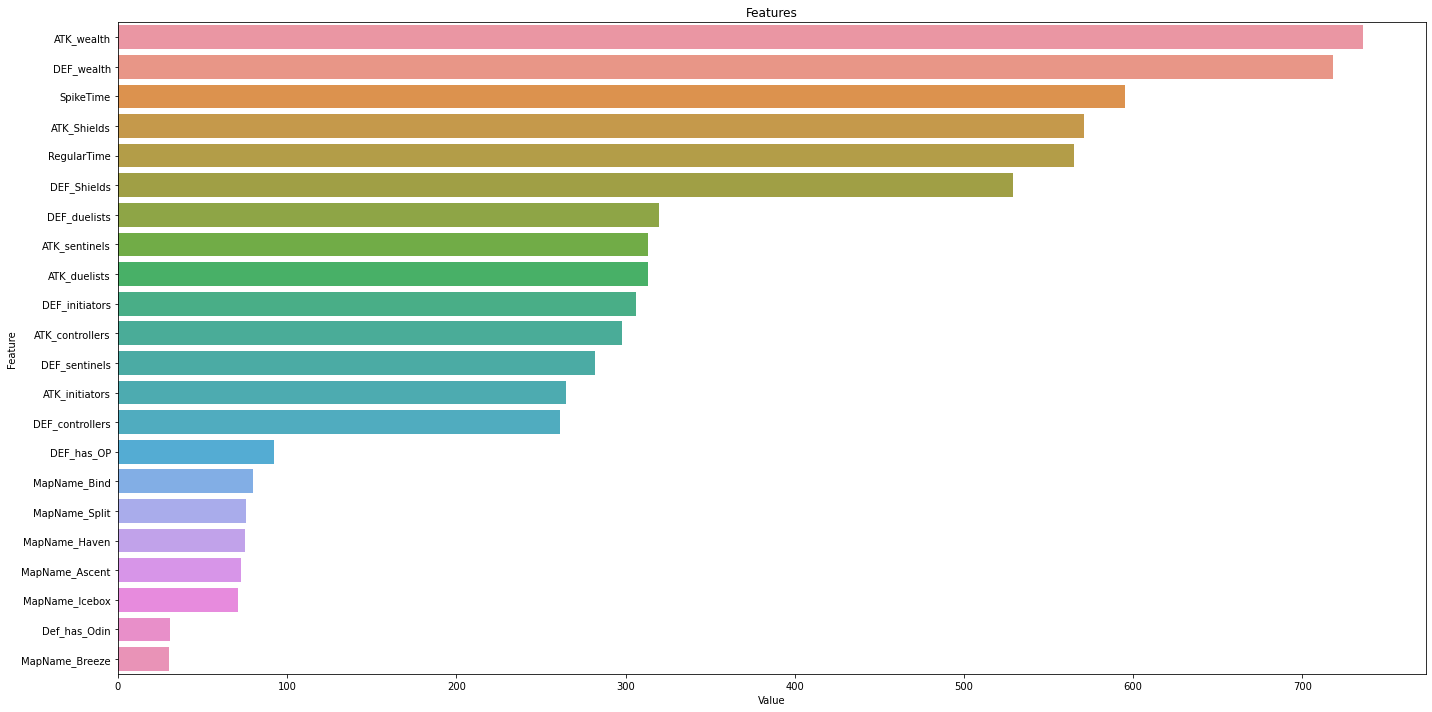

In [12]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Features')
plt.tight_layout()
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

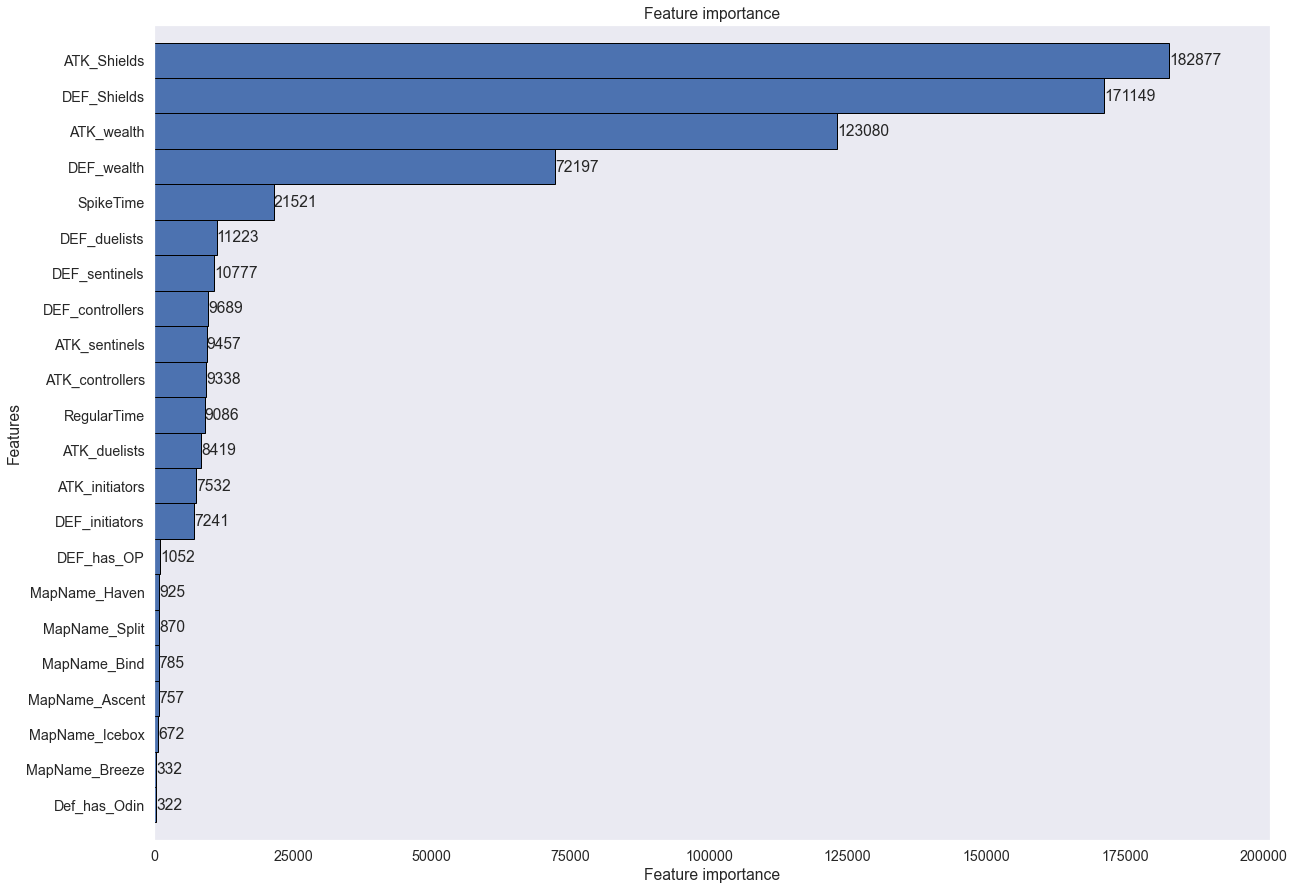

In [16]:
lightgbm.plot_importance(model, height=1, importance_type="gain", precision=0, grid=False, figsize=(20,15), edgecolor='black')

# <font color='blue'>MODEL PRECISION </font>

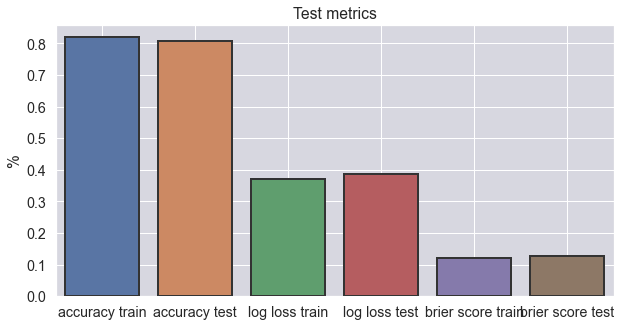

Wall time: 1.2 s


In [17]:
%%time
plt.figure(figsize = (10,5))

pred_proba = model.predict_proba(X_train)
pred_proba_test = model.predict_proba(X_test)

gmt = ["accuracy train", "accuracy test", "log loss train", "log loss test", "brier score train", "brier score test"]
metrics = {'Labels': gmt,
           'Value': [model.score(X_train, Y_train), model.score(X_test, Y_test),
                     log_loss(Y_train, pred_proba),log_loss(Y_test, pred_proba_test),
                     brier_score_loss(Y_train, pd.DataFrame(pred_proba)[1]),brier_score_loss(Y_test, pd.DataFrame(pred_proba_test)[1])]
           }

sns.set_context(rc = {'patch.linewidth': 2.0})
sns.set(font_scale=1.3)
ax = sns.barplot(x='Labels', y='Value', data=metrics, linewidth=2.0, edgecolor=".2", zorder=3, palette=sns.color_palette("deep"))

plt.ylabel('%')
#plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(.1))
ax.grid(linewidth=1, color='white', zorder=0)
ax.set_facecolor("#d7d7e0")
plt.title("Test metrics")
plt.show()

In [18]:
print("Brier score → {}".format(brier_score_loss(Y_test, pd.DataFrame(pred_proba_test)[1])))


Brier score → 0.12766284117101867


# <font color='blue'>REALIBITY CURVE </font>

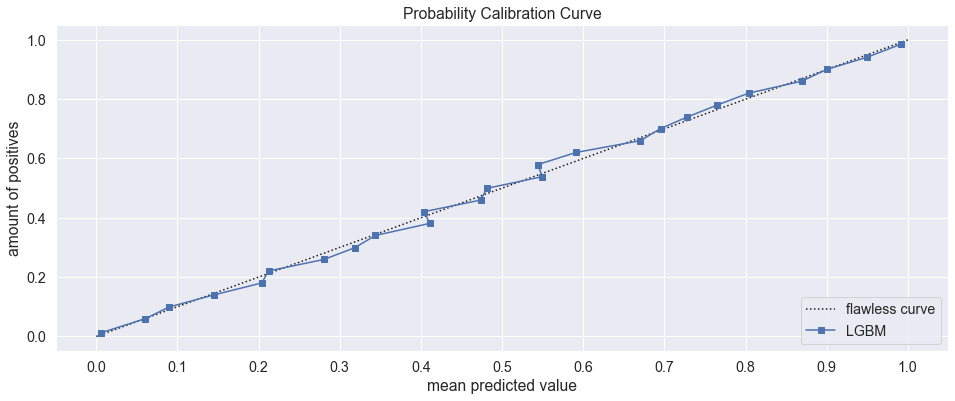

Wall time: 171 ms


Text(0.5, 0, 'mean predicted value')

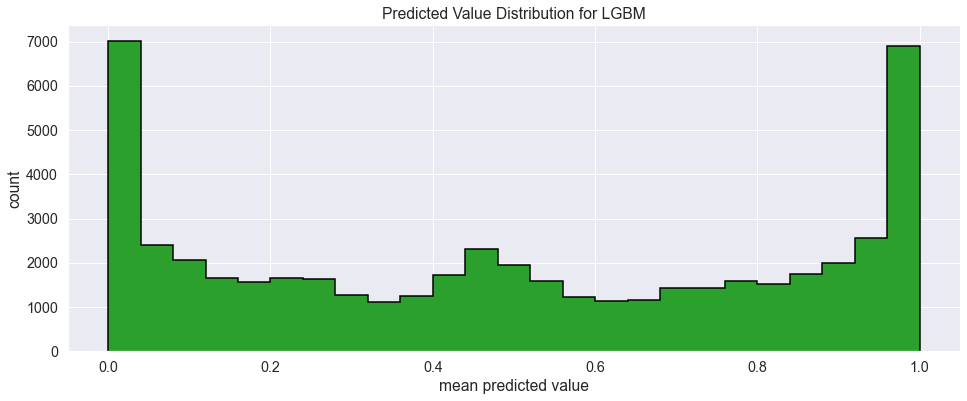

In [19]:
%%time
plt.figure(figsize=(16,6))
plt.plot([0,1], [0,1], 'k:', label='flawless curve')
x, y = calibration_curve(Y_test, pd.DataFrame(pred_proba_test)[1], n_bins=25)
plt.plot(x, y, 's-', label='LGBM')
plt.legend(loc='lower right')
plt.title('Probability Calibration Curve')
plt.ylabel('amount of positives')
plt.xlabel('mean predicted value')
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.1))
plt.show()

plt.figure(figsize=(16,6))
plt.hist(pd.DataFrame(pred_proba_test)[1], range=(0,1), bins=25, histtype="step", lw=2, fill=True, color='tab:green',
        edgecolor='black', linewidth=1.5)
plt.title('Predicted Value Distribution for LGBM')
plt.ylabel('count')
plt.xlabel('mean predicted value')

# <font color='blue'>CONFUSION MATRIX </font>

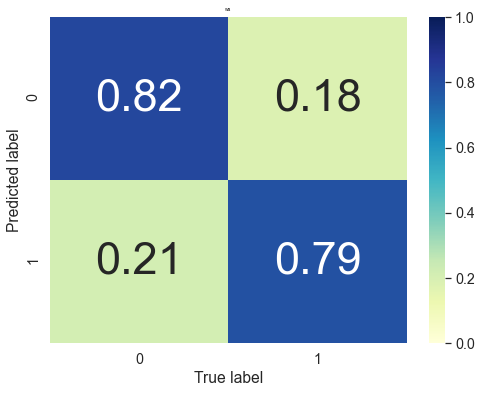

In [20]:
plt.figure(figsize = (8,6))
cm = confusion_matrix(Y_test, model.predict(X_test, num_iteration=50))
cm = (cm/cm.sum(axis=1).reshape(-1,1))

sns.heatmap(cm, cmap="YlGnBu", vmin=0., vmax=1., annot=True, annot_kws={'size':45})
plt.title("wa", fontsize = 5)
plt.ylabel('Predicted label')
plt.xlabel('True label')
plt.show()

In [21]:
Y_pred = model.predict(X_test)
classification_report(Y_test, Y_pred, output_dict=True)["weighted avg"]["f1-score"]

0.8065237874553753